# 로지스틱 회귀
: 선형 방정식을 이용한 회귀가 있지만 실제적으로 분류(Classification)에 대한 확률을 계산하는 모델

### 우선 KNN을 써보고, KNN이 왜 문제인지 확인해보자

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import pandas as pd
fishes = pd.read_csv('data/fishes.csv')
fishes.head()

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340


In [24]:
# Target으로 사용될 Species의 종류 알아보기
# fishes.Species.unique() # 종류만 알아본다
fishes.Species.value_counts() # 종류도 알아보면서 갯수도 셀 수 있다

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

### Feature와 Target Data 정리하기

In [25]:
# features = drop Species
fish_input = fishes.drop('Species', axis=1)

# to numpy array
fish_input = fish_input.values
fish_input.shape

(159, 5)

In [26]:
# Target
fish_target = fishes.Species.values
fish_target[:5]

array(['Bream', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

### Train과 Test 분리하기

In [27]:
# 데이터 분리
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target, random_state=42)

In [28]:
train_input[:5]

array([[720.    ,  35.    ,  40.6   ,  16.3618,   6.09  ],
       [500.    ,  45.    ,  48.    ,   6.96  ,   4.896 ],
       [  7.5   ,  10.5   ,  11.6   ,   1.972 ,   1.16  ],
       [110.    ,  22.    ,  23.5   ,   5.5225,   3.995 ],
       [140.    ,  20.7   ,  23.2   ,   8.5376,   3.2944]])

### 컬럼별 데이터 크기 차이가 너무 큼: 표준화하기로 결정
##### 바차트를 그려보거나 직접 보거나 무튼 눈으로 확인하고 결정해야 함

In [29]:
# 표준화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_input)
test_scaled = scaler.transform(test_input)

In [30]:
train_scaled[:5]

array([[ 0.91965782,  0.60943175,  0.81041221,  1.85194896,  1.00075672],
       [ 0.30041219,  1.54653445,  1.45316551, -0.46981663,  0.27291745],
       [-1.0858536 , -1.68646987, -1.70848587, -1.70159849, -2.0044758 ],
       [-0.79734143, -0.60880176, -0.67486907, -0.82480589, -0.27631471],
       [-0.71289885, -0.73062511, -0.70092664, -0.0802298 , -0.7033869 ]])

---
### KNN을 이용한 확률 예측

- 내 주위에 있는 10개가(k=10의 경우) 5개는 네모, 3개는 세모, 2개는 동그라미다. 나는 뭘까?
- 50% 확률로 네모, 30% 확률로 세모, 20% 확률로 동그라미
- 나는 네모다

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_scaled, train_target)

print('train score: ', knn.score(train_scaled, train_target))
print('test score: ', knn.score(test_scaled, test_target))

train score:  0.8907563025210085
test score:  0.85


In [33]:
# knn 분류 정보 보기
knn.classes_

array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
      dtype=object)

In [37]:
# test data 5개만 예측해보기
knn.predict(test_scaled[:5])

array(['Perch', 'Smelt', 'Pike', 'Perch', 'Perch'], dtype=object)

In [40]:
# test data의 확률 예측값 보기(왜 이렇게 예측했는지!)
import numpy as np

proba = knn.predict_proba((test_scaled[:5]))
np.round(proba, 4)

# 각각 'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish' 에 대응

# 주변에 3개씩만 봤기 때문에 0, 0.333, 0.6667, 1 로만 나온다 > 좀 못 미더움

array([[0.    , 0.    , 1.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.6667, 0.    , 0.3333, 0.    , 0.    ],
       [0.    , 0.    , 0.6667, 0.    , 0.3333, 0.    , 0.    ]])

- 3번째에서는 Perch가 어떻게 나왔길래 2:1로 예측되었을까?

In [42]:
# test data의 3번째에 대한 이웃들 알아보기
distance, indices = knn.kneighbors(test_scaled[3].reshape(1, -1))
# distance, indices = knn.kneighbors(test_scaled[3:4]) # 이렇게 해도 된다

In [43]:
train_target[indices]
# 주변 녀석들이 하나는 Roach, 2개는 Perch라서 Perch라고 예측했다는 것을 알 수 있음

array([['Roach', 'Perch', 'Perch']], dtype=object)

- KNN은 이웃의 갯수를 정해 사용하는 모델
- 현재 이웃의 갯수를 3으로 하였기 때문에 확률로 나올 수 있는 경우 수가 너무 적다(0, 1/3, 2/3, 3/3)

---
# 로지스틱 회귀를 이용한 확률 예측
- 데이터의 각 컬럼을 새로운 변수로 사용하는 다중회귀(다항X)를 이용한 확률
- a1X1 + a2X2 + ... + b
- 회귀식을 사용하기 때문에 로지스틱 회귀라고 하나 실질적으로 확률을 예측하는 모델임
- 선형회귀식에서 출발하였고, 딥러닝 모델의 기반이 됨.

- 구하려는 Z(target) = a1*무게 + a2*길이 + a3*대각선 + a4*두께 + b 로 구성되어 있다.
- 위의 식의 결과값은 -무한대 ~ +무한대의 범위로 값이 출력된다.
- 이를 해결하기 위해 Sigmoid 함수를 사용한다.
- Sigmoid 함수는 결과값이 0 ~ 1.0 사이인 수만 출력한다.
- 따라서 0.5를 기준으로 1에 가까우면 양성클래스, 0에 가까우면 음성클래스로 분류한다.
- 로지스틱 회귀를 사용할 경우 이 Sigmoid 함수를 로지스틱 함수라고 표현한다.

#### 회귀식을 확률로 변환할 수 있는 것은 sigmoid 뿐 (0~1사이로)

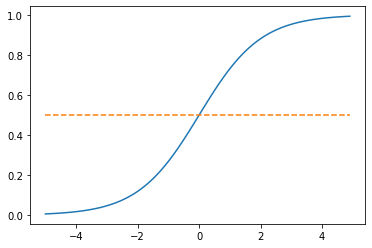

In [49]:
# Sigmoid Graph 출력하기
import matplotlib.pyplot as plt

z = np.arange(-5, 5, 0.1)
phi = 1 / (1 + np.exp(-z))

# 0.5 line
a = np.full((len(z)), 0.5) # z 갯수만큼 0.5로 채움 (구분해 보기 위한 선)

# 시그모이드 그래프
plt.plot(z, phi, '-', z, a, '--')
plt.show()

- 실질적으로 x값이 0이상이면 양성, 미만이면 음성클래스로 분류
- 이 분류(양성-음성 양자택일)를 이용하는 것이 predict 함수
- 각각의 확률수치를 알아보는 것이 predict_proba 함수

### 맞추려는게 이진분류(얘 아니면 쨰) 일 때 sigmoid를 쓰고 아니면 소프트맥스 씀

---
### 로지스틱 회귀로 이진분류 수행하기

In [50]:
# 생선 종류 2종류만 발췌하기
is_bream_or_smlet = (train_target == 'Bream') | (train_target == 'Smelt')
is_bream_or_smlet

array([ True, False,  True, False, False, False, False,  True, False,
       False, False,  True, False, False, False,  True,  True, False,
       False,  True, False,  True, False, False, False,  True, False,
       False,  True, False, False, False, False,  True, False, False,
        True,  True, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False,  True, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True, False,
       False,  True,  True, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False,  True, False,
        True, False, False,  True,  True, False, False, False, False,
       False, False, False, False,  True,  True, False, False,  True,
       False, False])

In [51]:
train_bream_smlet = train_scaled[is_bream_or_smlet]
target_bream_smlet = train_target[is_bream_or_smlet]

print(train_bream_smlet.shape)
print(target_bream_smlet.shape)
print(train_bream_smlet[:5])
print(target_bream_smlet[:5])



(33, 5)
(33,)
[[ 0.91965782  0.60943175  0.81041221  1.85194896  1.00075672]
 [-1.0858536  -1.68646987 -1.70848587 -1.70159849 -2.0044758 ]
 [ 0.63818253  0.56257661  0.73223951  1.64473401  0.50705737]
 [ 0.30041219  0.23459067  0.42823457  1.36042157  0.22329758]
 [ 0.9027693   0.70314202  0.88858491  1.89027545  0.85537174]]
['Bream' 'Smelt' 'Bream' 'Bream' 'Bream']


In [52]:
# 로지스틱 회귀 import
from sklearn.linear_model import LogisticRegression

# 로지스틱 회귀 모델 생성
lr = LogisticRegression()
lr.fit(train_bream_smlet, target_bream_smlet)

LogisticRegression()

In [54]:
lr.predict(train_bream_smlet[:5])

array(['Bream', 'Smelt', 'Bream', 'Bream', 'Bream'], dtype=object)

In [57]:
lr.classes_

array(['Bream', 'Smelt'], dtype=object)

In [56]:
lr.predict_proba(train_bream_smlet[:5])
# 0.667, 0.333 나오던 KNN보다 훨씬 더 나은 결과를 보여준다

array([[0.99759855, 0.00240145],
       [0.02735183, 0.97264817],
       [0.99486072, 0.00513928],
       [0.98584202, 0.01415798],
       [0.99767269, 0.00232731]])

#### 앞으로 배울 딥러닝은 로지스틱처럼 다 함수
##### sigmoid 대신 activation 함수라 부름

In [67]:
# 회귀식의 기울기(=가중치) > 앞으로 기울기라는 단어보다는 weight라는 단어를 더 쓰게 될 것
print(lr.coef_, lr.intercept_) # 1. 공식을 구한다

# Sigmoid 함수에 대입해 롹률값 구성
from scipy.special import expit

decision = lr.decision_function(train_bream_smlet[:5]) # 2. 값을 구한다
print(decision)

# 1이 나올 확률 하나만 구함! (Smelt의 확률)
print(expit(decision)) # 1이 나올 확률을 구한다

[[-0.4037798  -0.57620209 -0.66280298 -1.01290277 -0.73168947]] [-2.16155132]
[-6.02927744  3.57123907 -5.26568906 -4.24321775 -6.0607117 ]
[0.00240145 0.97264817 0.00513928 0.01415798 0.00232731]


---
# 로지스틱 회귀로 다중 분류 수행하기

In [70]:
lr = LogisticRegression(C=20, max_iter=100)
# C: 규제(릿지규제)이며 기본은 1이다. 숫자가 작을 수록 규제가 큰 것을 의미한다.
# max_iter: 최대 반복 횟수 > 모델의 정확성을 유지하기 위해 반복작업을 실시. 기본값은 100

lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.9327731092436975
0.925


In [71]:
# Test data 예측하기
lr.predict(test_scaled[:5])

array(['Perch', 'Smelt', 'Pike', 'Roach', 'Perch'], dtype=object)

In [75]:
lr.classes_

array(['Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'],
      dtype=object)

In [76]:
# 확률값 확인하기
proba = lr.predict_proba(test_scaled[:5])
np.round(proba, 3)
# Roach로 분류된 3번째 0.566이 제일 께름찍함

array([[0.   , 0.014, 0.841, 0.   , 0.136, 0.007, 0.003],
       [0.   , 0.003, 0.044, 0.   , 0.007, 0.946, 0.   ],
       [0.   , 0.   , 0.034, 0.935, 0.015, 0.016, 0.   ],
       [0.011, 0.034, 0.306, 0.007, 0.566, 0.   , 0.076],
       [0.   , 0.   , 0.904, 0.002, 0.09 , 0.002, 0.001]])

In [79]:
# 사용된 가중치들을 확인하기
print(lr.coef_, lr.intercept_)
# intercept는 물고기 별로 하나씩 총 7개

[[-1.4905421  -1.03388688  2.5981309   7.7010905  -1.19898821]
 [ 0.19743003 -2.00430042 -3.78377532  6.50494946 -1.99725866]
 [ 3.56169555  6.34534789 -8.49297599 -5.75593302  3.79378676]
 [-0.10575561  3.60083391  3.93006894 -3.61334796 -1.75124966]
 [-1.39815543 -6.07665211  5.2587158  -0.87346372  1.86121086]
 [-1.38756983  1.49434369  1.39400626 -5.67679984 -4.40003784]
 [ 0.6228974  -2.32568608 -0.90417059  1.71350459  3.69253675]] [-0.09382676 -0.2634882   3.24915811 -0.14626884  2.65333107 -6.78287518
  1.38396979]


- 다중회귀인 경우 각 샘플별로 회귀식을 구성하여 계산한다
- 이진분류처럼 클래스 하나를 계산해 1에서 빼는 방식으로 나머지 클래스를 구할 수 없다
- 각 Column과 Target을 일일이 계산해야 한다.
- 오차를 막기 위해 100번정도 반복해

### 확률분포 검증

In [81]:
# Decision Function 확인하기 > 회귀식에서 나온 값. 확률 아님
decision = lr.decision_function(test_scaled[:5])
np.round(decision, 2)

array([[ -6.5 ,   1.03,   5.16,  -2.73,   3.34,   0.33,  -0.63],
       [-10.86,   1.93,   4.77,  -2.4 ,   2.98,   7.84,  -4.26],
       [ -4.34,  -6.23,   3.17,   6.48,   2.35,   2.43,  -3.87],
       [ -0.68,   0.45,   2.65,  -1.18,   3.26,  -5.75,   1.26],
       [ -6.4 ,  -1.99,   5.81,  -0.11,   3.5 ,  -0.11,  -0.71]])

> 이것들을 Sigmoid를 해버리면 각각의 값이 생성되어 확률의 합이 1을 넘어버린다.

##### 이 경우 또다른 활성화(Activation) 함수인 Softmax를 사용한다.

# SoftMax 함수

In [87]:
from scipy.special import softmax

proba = softmax(decision, axis=1)
print(np.round(proba, 3))


[[0.    0.014 0.841 0.    0.136 0.007 0.003]
 [0.    0.003 0.044 0.    0.007 0.946 0.   ]
 [0.    0.    0.034 0.935 0.015 0.016 0.   ]
 [0.011 0.034 0.306 0.007 0.566 0.    0.076]
 [0.    0.    0.904 0.002 0.09  0.002 0.001]]
